-------------------------------------------------------------------------------------------------------------------
Implementation of : "Online Label Recovery for Deep Learning-based communication through Error Correcting codes"

Author : Eric Soubigou

Date : Spring 2019

-------------------------------------------------------------------------------------------------------------------

Description :  Creation of a DFE like with Deep Learning technologies

In [1]:
# Install libraries :
!pip3 install --user git+git://github.com/veeresht/CommPy.git@master
!pip3 install --user torch
!pip3 install --user matplotlib
!pip3 install --user scipy
print("================== DONE ! ==================")

  Cloning git://github.com/veeresht/CommPy.git (to revision master) to /tmp/pip-req-build-fx5czc4h
  Running command git clone -q git://github.com/veeresht/CommPy.git /tmp/pip-req-build-fx5czc4h
  Stored in directory: /tmp/pip-ephem-wheel-cache-1jbhmiod/wheels/d1/6a/31/8ddc70e8eb8a1c3ad344032ed43b4ebfccc41007e8850226d0
Successfully built scikit-commpy
================== DONE ! ==================


In [3]:
## Imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import pickle # For saving file
import copy as cpy

# Scipy
import scipy as sp
from scipy import signal

# Numpy
import numpy as np
np.set_printoptions(precision=2)

# Random
import random

# Compy
from commpy.filters import *
import commpy as cp
## Simulation import
from commpy.channelcoding.convcode import Trellis, conv_encode, viterbi_decode
from commpy.modulation import *

# For DL libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set the use of device which will be used 
if torch.cuda.is_available():
    device = torch.device('cuda')
    FloatTensor = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    FloatTensor = torch.FloatTensor


In [ ]:
# Launch simulation
from MonteCarlo import *

simulation_param_dict = {
    "m_c_parameters": {
        "min_error_frame": 100,
        "targeted_fer": 1e-2,
        "step_db": 2,
        "min_eb_n0": 0,
        "max_eb_n0": 50,
    },
    "channel_parameters": {
        "channel_type": "Proakis_C",
        "non_lin_coeff": 0,
        "iq_imbalance": None,
        "channel_taps": np.array([1, 2, 3, 2, 1]),
    },
    "frame_length": 256,
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
    "pre_equalizer": {
        "model_path": None,
        "feed_back_freq": 0,
    }
}

# Launch the simulation
monte_carlo_simulation(simulation_param_dict)

Results will be printed in :  ./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0_iq_im_None_snr_0_to_50_step_2_.pickle
At  0.0  % , BER =  0.4611328125 , FER =  1.0  for  Eb/N0 =  0  dB , SNR =  0.0 dB  nb_tries =  100
At  4.0  % , BER =  0.403046875 , FER =  1.0  for  Eb/N0 =  2  dB , SNR =  2.0 dB  nb_tries =  100
At  8.0  % , BER =  0.345078125 , FER =  1.0  for  Eb/N0 =  4  dB , SNR =  4.0 dB  nb_tries =  100
At  12.0  % , BER =  0.29 , FER =  1.0  for  Eb/N0 =  6  dB , SNR =  6.0 dB  nb_tries =  100
At  16.0  % , BER =  0.2537109375 , FER =  1.0  for  Eb/N0 =  8  dB , SNR =  8.0 dB  nb_tries =  100
At  20.0  % , BER =  0.2183203125 , FER =  1.0  for  Eb/N0 =  10  dB , SNR =  10.0 dB  nb_tries =  100
At  24.0  % , BER =  0.166171875 , FER =  1.0  for  Eb/N0 =  12  dB , SNR =  12.0 dB  nb_tries =  100
At  28.0  % , BER =  0.11171875 , FER =  1.0  for  Eb/N0 =  14  dB , SNR =  14.0 dB  nb_tries =  100
At  32.0  % , BER =  0.0753125 , FER =  1.0  for  Eb/N0 =  16  dB , SNR = 

In [5]:
from DataSetManager import *

# Data set Creation
data_set_generation_param_dict = {
    "eb_n0_db": 10,
    "channel_parameters": {
        "channel_type": "AWGN",
        "non_lin_coeff": 0.5,
        "iq_imbalance": 0.5,
        "channel_taps": np.array([1]),
    },
    "frame_length": 2000140, # 1000040
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
}

create_data_set(data_set_generation_param_dict)

shape comparison samples and targets (35160, 72) (35160, 72)
Data set created at ./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_10_proakis_C.pt


Splitting of data set: 
	Training set size : 28128/35160 
	Validation set size : 3516/35160 
	Validation test size : 3516/35160
Can't load ./models/pre_eq_model_test => Generate a new model
Epoch 300/300; training MSE : 0.0001565646380186081; validation MSE : 0.00040375778917223215

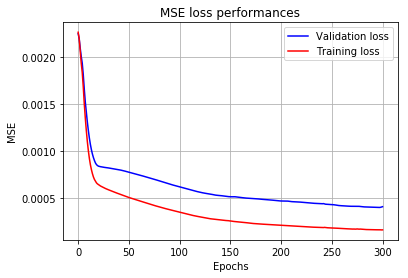

In [102]:
#  Train the NN-prequlizer
from PreEqualizer import *
from torch.utils.data import DataLoader

# Load the data set
data_set = OFDMSamplesDataset(
    "./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_10_proakis_C.pt"
)
# Spliting policies
training_size = int(0.8 * len(data_set))
validation_size = int(0.1 * len(data_set))
test_size = int(0.1 * len(data_set))

print(
    "Splitting of data set: \n\tTraining set size : {}/{} \n\tValidation set size : {}/{} \n\tValidation test size : {}/{}\n".format(
        str(training_size),
        str(len(data_set)),
        str(validation_size),
        str(len(data_set)),
        str(test_size),
        str(len(data_set)),
    )
)

# Split data set
training_set, validation_set, test_set = torch.utils.data.random_split(
    data_set, [training_size, validation_size, test_size]
)

# Create a data loaders.
training_dataloader = DataLoader(dataset=training_set, batch_size=2000, shuffle=False)
validation_dataloader = DataLoader(
    dataset=validation_set, batch_size=2000, shuffle=False
)

# Creation of the PreEqualizer
model_path = "./models/pre_eq_model_test"

pre_eq = PreEqualizer(data_set.get_number_of_carriers())

try:
    pre_eq.load_state_dict(torch.load(model_path))
except:
    print("Can't load {} => Generate a new model\n".format(model_path))

# Train the Pre-Equalizer in standalone mode
PreEqualizer.train(
    pre_eq, training_dataloader, validation_dataloader, nb_epochs=300, sgd_step=0.001
)

# Save the model after training
torch.save(pre_eq.state_dict(), model_path)

Results will be printed in :  ./results/OFDM_eq_MMSE_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_30_step_2_pre_equalizer_update_0.pickle


/home/eric/.local/lib/python3.6/site-packages/commpy/modulation.py:77: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  index_list))


At  0.0  % , BER =  0.4875 , FER =  1.0  for  Eb/N0 =  0  dB , SNR =  0.0 dB  nb_tries =  100
At  6.0  % , BER =  0.4568359375 , FER =  1.0  for  Eb/N0 =  2  dB , SNR =  2.0 dB  nb_tries =  100
At  13.0  % , BER =  0.3573046875 , FER =  1.0  for  Eb/N0 =  4  dB , SNR =  4.0 dB  nb_tries =  100
At  20.0  % , BER =  0.1240625 , FER =  1.0  for  Eb/N0 =  6  dB , SNR =  6.0 dB  nb_tries =  100
At  26.0  % , BER =  0.007157088926174496 , FER =  0.6711409395973155  for  Eb/N0 =  8  dB , SNR =  8.0 dB  nb_tries =  149
At  33.0  % , BER =  7.089652874730296e-05 , FER =  0.012691965985531158  for  Eb/N0 =  10  dB , SNR =  10.0 dB  nb_tries =  7879
At  40.0  % , BER =  0.0 , FER =  0.0  for  Eb/N0 =  12  dB , SNR =  12.0 dB  nb_tries =  10000


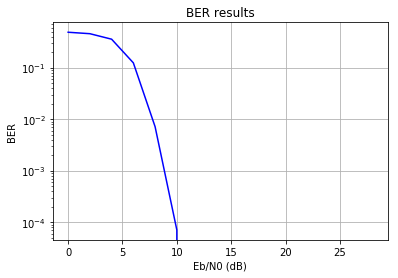

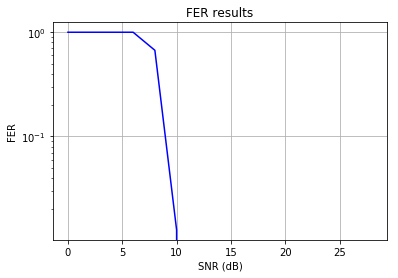

In [29]:
# Launch simulation
from MonteCarlo import *

# Model loading
model_path = "./models/pre_eq_model_test"

simulation_param_dict = {
    "m_c_parameters": {
        "min_error_frame": 100,
        "targeted_fer": 1e-2,
        "step_db": 2,
        "min_eb_n0": 0,
        "max_eb_n0": 30,
    },
    "channel_parameters": {
        "channel_type": "AWGN",
        "non_lin_coeff": 0.5,
        "iq_imbalance": 0.5,
        "channel_taps": np.array([1]),
    },
    "frame_length": 256,
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
    "pre_equalizer": {
        "model_path": model_path,
        "feed_back_freq": 0,
    }
}

# Launch the simulation
monte_carlo_simulation(simulation_param_dict, "test")

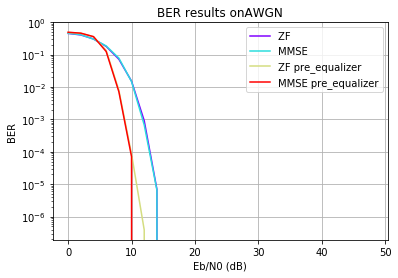

In [31]:
# Print of performances
from Utils import *

res_MMSE = load_results("./results/OFDM_eq_MMSE_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_50_step_2_.pickle");
res_ZF = load_results("./results/OFDM_eq_ZF_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_50_step_2_.pickle");
res_ZF_pre_eq = load_results("./results/OFDM_eq_ZF_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_30_step_2_pre_equalizer_update_0.pickle")
res_MMSE_pre_eq = load_results("./results/OFDM_eq_MMSE_coding_0.5_AWGN_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_30_step_2_pre_equalizer_update_0.pickle")

plot_performance([res_ZF, res_MMSE, res_ZF_pre_eq, res_MMSE_pre_eq])
